In [ ]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model, single_mtd_simulation, mtd_ai_simulation, multiple_mtd_simulation, specific_multiple_mtd_simulation
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi


logging.basicConfig(format='%(message)s', level=logging.INFO)

In [ ]:
create_experiment_snapshots([25, 50, 75, 100])

In [ ]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 3000
mtd_interval = [100]
network_size = [25]
total_nodes = 300
new_network = True
features = ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure",  "overall_asr_avg", "roa", "shortest_path_variability", "risk"]
model = "main_network_final_host_compromise_ratio#exposed_endpoints#attack_path_exposure#overall_asr_avg#roa#shortest_path_variability#risk"
trial = 2

mtd_strategies = [
    CompleteTopologyShuffle,
    # HostTopologyShuffle,
    IPShuffle,
    OSDiversity,
    # PortShuffle,
    # OSDiversityAssignment,
    ServiceDiversity,
    # UserShuffle
]



In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class RadarPlot:
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network, features, model, trial):
        # Learning Parameters
        self.epsilon = epsilon  # exploration rate

        # Simulator Settings
        self.start_time = start_time
        self.finish_time = finish_time
        self.schemes = [ 'mtd_ai', 'simultaneous', 'random', 'alternative']
        self.total_nodes = total_nodes
        self.new_network = new_network
        self.features = features
        self.model = model
        self.trial = trial
        
        self.mtd_strategies = [
            CompleteTopologyShuffle,
            # HostTopologyShuffle,
            IPShuffle,
            OSDiversity,
            # PortShuffle,
            # OSDiversityAssignment,
            ServiceDiversity,
            # UserShuffle
        ]
        self.mtd_interval = mtd_interval
        self.network_size = network_size
        self.normalization_values = self.get_scheme_values('nomtd')




    def get_scheme_values(self, scheme):
        # Simulate and stack nomtd DataFrames
        dfs = []
        for _ in range(self.trial):
            if scheme == 'nomtd':
                mtd = pd.DataFrame(single_mtd_simulation("no_mtd", [None], checkpoint=list(np.arange(0.01, 1.01, 0.01)), mtd_interval=self.mtd_interval,network_size=self.network_size)).drop('Name', axis=1)
            elif scheme == 'mtd_ai':
                mtd = pd.DataFrame(mtd_ai_simulation('mtd_ai', model, start_time, finish_time, total_nodes, new_network = new_network, mtd_interval=self.mtd_interval,network_size=self.network_size )).drop('Name', axis=1)
            else:
                mtd = pd.DataFrame(specific_multiple_mtd_simulation(scheme, self.mtd_strategies, scheme, mtd_interval=self.mtd_interval,network_size=self.network_size)).drop('Name', axis=1)
                
            dfs.append(mtd)
        stacked_nomtd = pd.concat(dfs, ignore_index=True)
        # Calculate median for normalization
        median_df = stacked_nomtd.groupby(['mtd_interval', 'network_size']).median().loc[self.mtd_interval[0],self.network_size[0]].to_dict()

        

        return median_df

    def scale_metrics(self, metrics_dict, normalization_dict):
        # Define which metrics should be maximized and which should be minimized
        metrics_to_maximize = {'ASR', 'ROA', 'exposed_endpoints'}  
        metrics_to_minimize = {'host_compromise_ratio', 'time_to_compromise', 'attack_path_exposure'}  

        scaled_metrics = {}

        for key, value in metrics_dict.items():
            if key in normalization_dict:
                norm_value = normalization_dict[key]

                if norm_value != 0:
                    if key in metrics_to_maximize:
                        # Normalize by dividing the metric value by the normalization value
                        scaled_metrics[key] = value / norm_value
                    elif key in metrics_to_minimize:
                        # Inverse the ratio for metrics to be minimized
                        scaled_metrics[key] = 1 / (value / norm_value)
                    else:
                        # Handle cases where the metric is not in either category
                        scaled_metrics[key] = value / norm_value
                else:
                    # Handle the case where norm_value is zero
                    scaled_metrics[key] = 1  # Or any other placeholder value as needed
            else:
                # Handle cases where normalization value is not defined
                scaled_metrics[key] = value  # Or handle differently as needed
        return scaled_metrics


    def plot_single_radar(self, metrics_values, scheme, std_dev_values=None):
        labels = list(metrics_values.keys())
        values = list(metrics_values.values())
        num_vars = len(labels)

        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        values += values[:1]
        if std_dev_values:
            std_dev_values = list(std_dev_values.values())  # Assuming std_dev_values is also a dictionary
            std_dev_values += std_dev_values[:1]
        labels += labels[:1]  # Close the circle by repeating the first label

        # Create radar plot
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot data
        ax.fill(angles, values, color='blue', alpha=0.25)
        ax.plot(angles, values, color='blue', linewidth=2, label=scheme)

        # Add error bars if provided
        if std_dev_values:
            for i in range(num_vars):
                angle = angles[i]
                value = values[i]
                error = std_dev_values[i]
                ax.errorbar(angle, value, yerr=error, fmt='o', color='blue', capsize=5, elinewidth=2)

        # Add score labels
        for i in range(num_vars):
            angle = angles[i]
            value = values[i]
            ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Labels
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])  # Set ticks without the last angle
        ax.set_xticklabels(labels[:-1], rotation=45, ha='right')

        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()




In [32]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network, features, model, trial)

NoMTD
NoMTD


In [33]:
radar.normalization_values

{'MEF': 0.0,
 'ASR': 0.8259615384615384,
 'time_to_compromise': 1458.232709064743,
 'host_compromise_ratio': 0.405,
 'exposed_endpoints': 5.0,
 'attack_path_exposure': 0.676888888888889,
 'ROA': 0.14152721613581154,
 'risk': 0.6184601025461585,
 'shortest_path_variability': 0.0}

In [34]:

labels = ['MEF', 'ASR', 'time_to_compromise', 'host_compromise_ratio', 'exposed_endpoints', 'attack_path_exposure', 'ROA', 'risk', 'shortest_path_variability']
results = {}
actual_results = {}
for scheme in radar.schemes:
    scheme_result = radar.get_scheme_values(scheme)
    scaled_metrics = radar.scale_metrics(scheme_result,radar.normalization_values)
    results[scheme] = scaled_metrics
    actual_results[scheme] = scheme_result


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
MTD: CompleteTopologyShuffle triggered 0.0s
MTD: IPShuffle triggered 0.0s
MTD: OSDiversity triggered 0.0s
MTD: ServiceDiversity triggered 0.0s
MTD: CompleteTopologyShuffle triggered 100.4s
MTD: CompleteTopologyShuffle suspended at 100.4s due to resource occupation
MTD: IPShuffle triggered 100.4s
MTD: IPShuffle suspended at 100.4s due to resource occupation
MTD: OSDiversity triggered 100.4s
MTD: OSDiversity suspended at 100.4s due to resource occupation
MTD: ServiceDiversity triggered 100.4s
MTD: ServiceDiversity suspended at 100.4s due to resource occupation
MTD: Interrupted SCAN_PORT at 120.8s!
MTD: CompleteTopologyShuffle triggered 201.2s
MTD: Interrupted EXPLOIT_VULN at 230.9s!
MTD: Int

simultaneous


MTD: CompleteTopologyShuffle triggered 1627.5s
MTD: IPShuffle triggered 1627.5s
MTD: OSDiversity triggered 1627.5s
MTD: ServiceDiversity triggered 1627.5s
MTD: CompleteTopologyShuffle triggered 1727.8s
MTD: CompleteTopologyShuffle suspended at 1727.8s due to resource occupation
MTD: IPShuffle triggered 1727.8s
MTD: IPShuffle suspended at 1727.8s due to resource occupation
MTD: OSDiversity triggered 1727.8s
MTD: OSDiversity suspended at 1727.8s due to resource occupation
MTD: ServiceDiversity triggered 1727.8s
MTD: ServiceDiversity suspended at 1727.8s due to resource occupation
MTD: Interrupted SCAN_PORT at 1747.7s!
MTD: CompleteTopologyShuffle triggered 1828.3s
MTD: Interrupted EXPLOIT_VULN at 1858.2s!
MTD: Interrupted EXPLOIT_VULN at 1978.5s!
MTD: IPShuffle triggered 1978.5s
MTD: Interrupted EXPLOIT_VULN at 2089.6s!
MTD: OSDiversity triggered 2189.9s
MTD: ServiceDiversity triggered 2269.9s
MTD: CompleteTopologyShuffle triggered 2441.2s
MTD: IPShuffle triggered 2441.2s
MTD: OSDiversit

simultaneous


MTD: CompleteTopologyShuffle triggered 0.0s
MTD: CompleteTopologyShuffle triggered 100.2s
MTD: Interrupted EXPLOIT_VULN at 120.5s!
MTD: CompleteTopologyShuffle triggered 200.3s
MTD: CompleteTopologyShuffle triggered 300.4s
MTD: Interrupted EXPLOIT_VULN at 320.6s!
MTD: CompleteTopologyShuffle triggered 400.5s
MTD: ServiceDiversity triggered 500.7s
MTD: Interrupted EXPLOIT_VULN at 521.2s!
MTD: OSDiversity triggered 601.0s
MTD: CompleteTopologyShuffle triggered 701.3s
MTD: CompleteTopologyShuffle triggered 801.5s
MTD: Interrupted EXPLOIT_VULN at 821.3s!
MTD: CompleteTopologyShuffle triggered 902.5s
MTD: IPShuffle triggered 1002.5s
MTD: Interrupted EXPLOIT_VULN at 1022.6s!
MTD: IPShuffle triggered 1103.2s
MTD: IPShuffle triggered 1203.5s
MTD: Interrupted EXPLOIT_VULN at 1213.4s!
MTD: IPShuffle triggered 1304.0s
MTD: ServiceDiversity triggered 1404.2s
MTD: Interrupted SCAN_PORT at 1414.0s!
MTD: OSDiversity triggered 1504.3s


random


MTD: ServiceDiversity triggered 1604.3s
MTD: OSDiversity triggered 1704.4s
MTD: CompleteTopologyShuffle triggered 1804.6s
MTD: IPShuffle triggered 1905.0s
MTD: Interrupted EXPLOIT_VULN at 1924.8s!
MTD: IPShuffle triggered 2005.2s
MTD: ServiceDiversity triggered 2106.0s
MTD: Interrupted SCAN_PORT at 2115.2s!
MTD: OSDiversity triggered 2206.1s
MTD: OSDiversity triggered 2306.5s
MTD: ServiceDiversity triggered 2406.7s
MTD: ServiceDiversity triggered 2506.9s
MTD: CompleteTopologyShuffle triggered 2607.7s
MTD: OSDiversity triggered 2708.8s
MTD: Interrupted EXPLOIT_VULN at 2729.3s!
MTD: ServiceDiversity triggered 2809.3s
MTD: CompleteTopologyShuffle triggered 2909.4s
MTD: CompleteTopologyShuffle triggered 3010.7s
MTD: Interrupted EXPLOIT_VULN at 3029.6s!
MTD: CompleteTopologyShuffle triggered 3110.8s
MTD: ServiceDiversity triggered 3211.2s
MTD: Interrupted EXPLOIT_VULN at 3231.4s!
MTD: OSDiversity triggered 3311.4s
MTD: IPShuffle triggered 3413.4s
MTD: OSDiversity triggered 3513.5s
MTD: Inte

random


MTD: ServiceDiversity triggered 5427.0s
MTD: CompleteTopologyShuffle triggered 5527.3s
MTD: IPShuffle triggered 5629.2s
MTD: Interrupted EXPLOIT_VULN at 5647.4s!
MTD: IPShuffle triggered 5730.7s
MTD: OSDiversity triggered 5831.9s
MTD: Interrupted SCAN_PORT at 5840.9s!
MTD: ServiceDiversity triggered 5932.2s
MTD: CompleteTopologyShuffle triggered 6032.3s
MTD: IPShuffle triggered 6132.4s
MTD: Interrupted EXPLOIT_VULN at 6152.4s!
MTD: IPShuffle triggered 6232.8s
MTD: OSDiversity triggered 6332.9s
MTD: Interrupted EXPLOIT_VULN at 6343.7s!
MTD: ServiceDiversity triggered 6433.0s
MTD: CompleteTopologyShuffle triggered 0.0s
MTD: IPShuffle triggered 100.3s
MTD: Interrupted EXPLOIT_VULN at 120.3s!
MTD: IPShuffle triggered 200.8s
MTD: OSDiversity triggered 301.9s
MTD: Interrupted EXPLOIT_VULN at 311.0s!
MTD: ServiceDiversity triggered 402.1s
MTD: CompleteTopologyShuffle triggered 502.2s
MTD: IPShuffle triggered 603.6s
MTD: Interrupted EXPLOIT_VULN at 622.7s!
MTD: IPShuffle triggered 703.9s
MTD: 

alternative


MTD: CompleteTopologyShuffle triggered 2009.1s
MTD: IPShuffle triggered 2109.9s
MTD: Interrupted EXPLOIT_VULN at 2129.9s!
MTD: IPShuffle triggered 2210.0s
MTD: OSDiversity triggered 2310.3s
MTD: Interrupted SCAN_PORT at 2320.0s!
MTD: ServiceDiversity triggered 2410.7s
MTD: CompleteTopologyShuffle triggered 2511.0s
MTD: IPShuffle triggered 2611.3s
MTD: Interrupted EXPLOIT_VULN at 2631.0s!
MTD: IPShuffle triggered 2711.8s
MTD: OSDiversity triggered 2812.3s
MTD: Interrupted EXPLOIT_VULN at 2822.3s!
MTD: ServiceDiversity triggered 2912.7s
MTD: CompleteTopologyShuffle triggered 3013.1s
MTD: IPShuffle triggered 3113.4s
MTD: Interrupted EXPLOIT_VULN at 3133.2s!
MTD: IPShuffle triggered 3214.2s
MTD: OSDiversity triggered 3314.7s
MTD: Interrupted EXPLOIT_VULN at 3324.6s!
MTD: ServiceDiversity triggered 3415.3s
MTD: CompleteTopologyShuffle triggered 3515.9s
MTD: IPShuffle triggered 3618.6s
MTD: Interrupted SCAN_PORT at 3636.1s!
MTD: IPShuffle triggered 3719.1s
MTD: OSDiversity triggered 3819.4s


alternative


In [35]:
print("Raw values")
for scheme, data in results.items():
    print(scheme, actual_results[scheme])
print("nomtd", radar.normalization_values)

Raw values
mtd_ai {'MEF': 0.006702756417187616, 'ASR': 0.2760989010989011, 'time_to_compromise': 1543.3993350921796, 'host_compromise_ratio': 0.015, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.19594179894179894, 'ROA': 0.4760090702684204, 'risk': 1.6802404077054425, 'shortest_path_variability': 18.6}
simultaneous {'MEF': 0.009996507868674119, 'ASR': 0.22503373819163291, 'time_to_compromise': 3122.000472235795, 'host_compromise_ratio': 0.45, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.8177301587301588, 'ROA': 0.3976169438374572, 'risk': 1.1097108972617113, 'shortest_path_variability': 0.0}
random {'MEF': 0.008197389269398545, 'ASR': 0.27046783625730997, 'time_to_compromise': 3184.7226717046015, 'host_compromise_ratio': 0.45, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.7056666666666666, 'ROA': 0.31233363218420557, 'risk': 1.054228440451582, 'shortest_path_variability': 0.0}
alternative {'MEF': 0.007973481584236702, 'ASR': 0.22430750702529106, 'time_to_compromise':

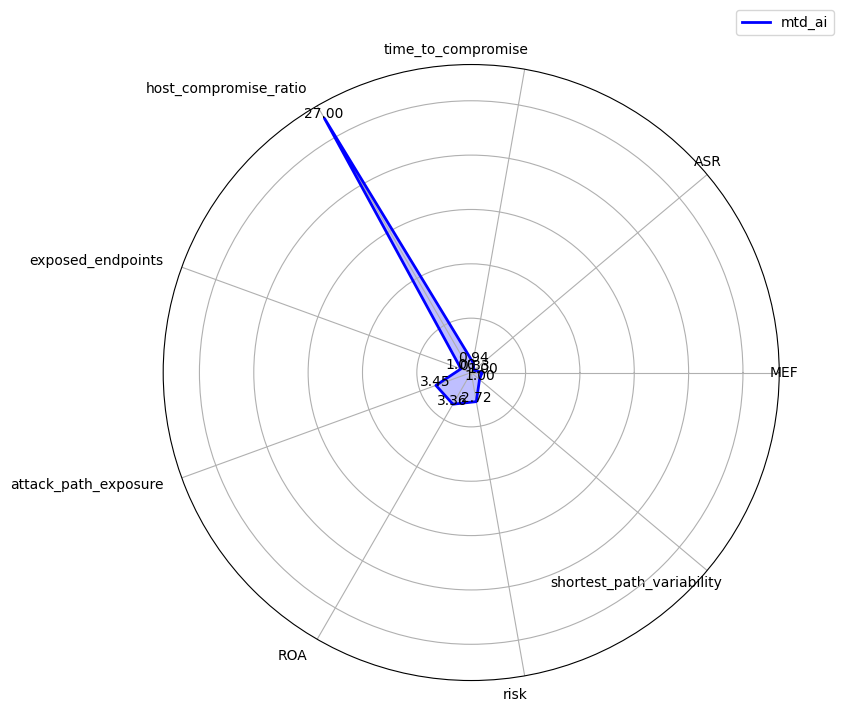

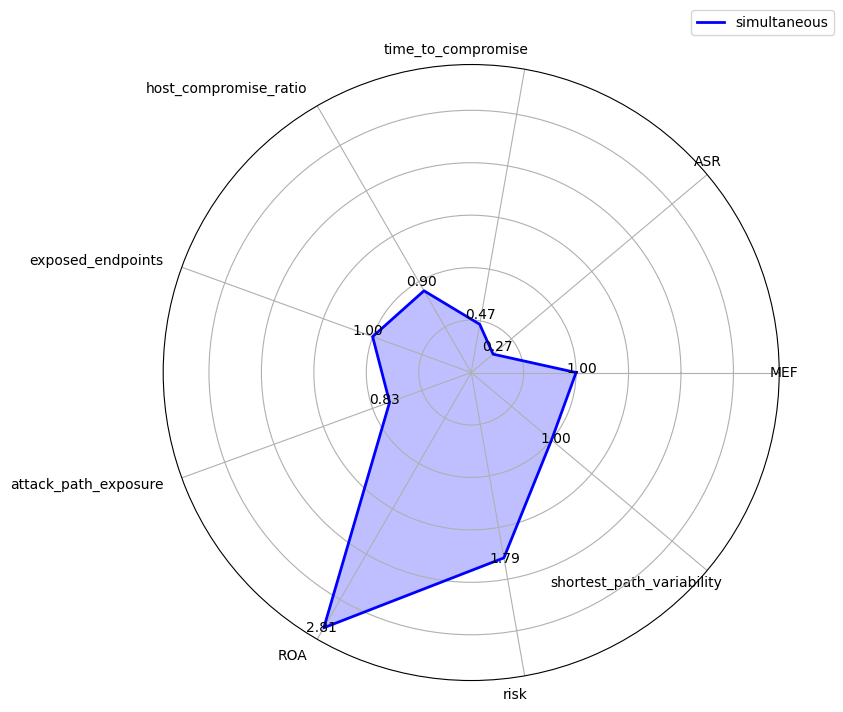

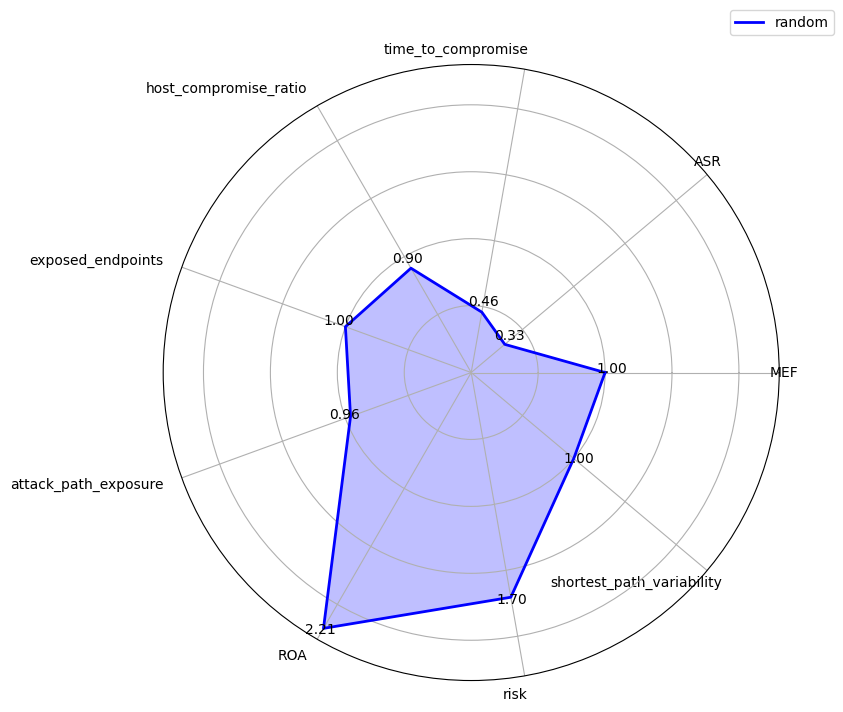

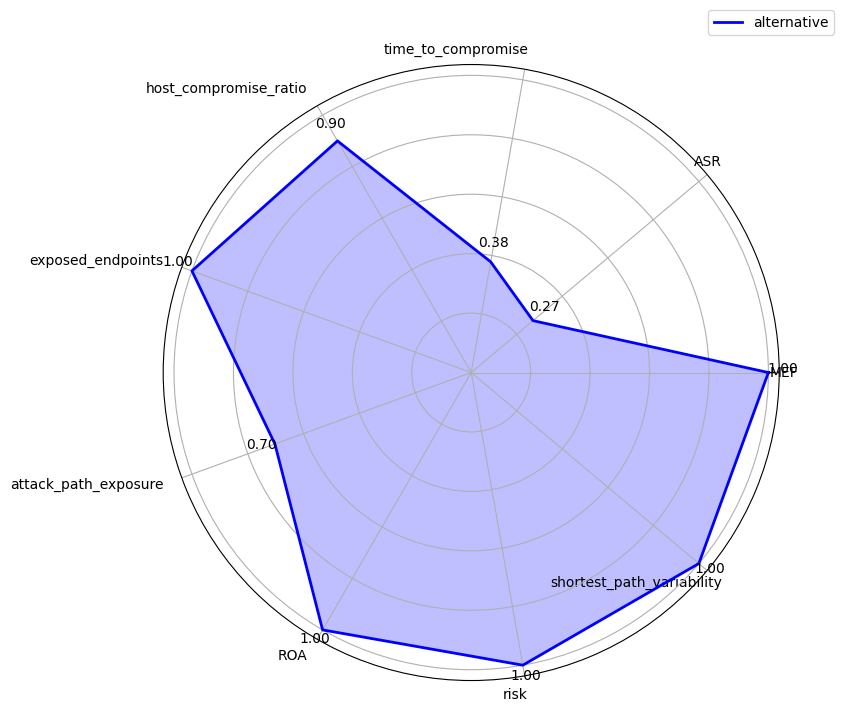

In [36]:
for scheme, data in results.items():
    radar.plot_single_radar(data, scheme, std_dev_values=None)
   